# Test 2: Finetuned Models (DistilBERT & RoBERTa)

Testing if finetuned transformer models have **bias towards resume writing style**.

**Metrics:** Accuracy, Inconsistency Rate, Rank Difference

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../Test 2 Data/test2_resumes.csv")
styles = ['neutral', 'overstated', 'understated']
model_names = ['distilbert', 'roberta']

# Check if predictions already exist
if os.path.exists("finetuned_predictions.csv"):
    print("Loading existing predictions...")
    results_df = pd.read_csv("finetuned_predictions.csv")
    print(f"Loaded {len(results_df)} predictions")
else:
    print("Running predictions...")
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import warnings
    warnings.filterwarnings('ignore')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    MODEL_PATHS = {
        'distilbert': '../Smaller Models/distilbert_resume_level',
        'roberta': '../Smaller Models/roberta_resume_level'
    }
    
    models, tokenizers = {}, {}
    for name, path in MODEL_PATHS.items():
        tokenizers[name] = AutoTokenizer.from_pretrained(path)
        models[name] = AutoModelForSequenceClassification.from_pretrained(path).to(device)
        models[name].eval()
    
    id2label = {0: 'junior', 1: 'mid', 2: 'senior'}
    
    def predict(model_name, text):
        inputs = tokenizers[model_name](text, return_tensors="pt", truncation=True, max_length=512, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = models[model_name](**inputs)
        return id2label[torch.argmax(outputs.logits, dim=1).item()]
    
    results = []
    for idx, row in df.iterrows():
        for style in styles:
            for model_name in model_names:
                pred = predict(model_name, str(row[style]))
                results.append({'idx': idx, 'true_seniority': row['seniority'], 'style': style,
                               'model': model_name, 'prediction': pred, 'correct': pred == row['seniority']})
        if (idx + 1) % 20 == 0:
            print(f"Processed {idx + 1}/{len(df)}")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv("finetuned_predictions.csv", index=False)
    print(f"Saved {len(results_df)} predictions")

# Add rank columns
seniority_rank = {'junior': 0, 'mid': 1, 'senior': 2}
results_df['true_rank'] = results_df['true_seniority'].map(seniority_rank)
results_df['pred_rank'] = results_df['prediction'].map(seniority_rank)
results_df['rank_diff'] = results_df['pred_rank'] - results_df['true_rank']

Loading existing predictions...
Loaded 720 predictions


---
## Metric 1: Accuracy by Style

In [2]:
print("ACCURACY BY STYLE")
print("=" * 50)
for model_name in model_names:
    print(f"\n{model_name.upper()}")
    model_df = results_df[results_df['model'] == model_name]
    for style in styles:
        acc = model_df[model_df['style'] == style]['correct'].mean()
        print(f"  {style:<15}: {acc:.1%}")

ACCURACY BY STYLE

DISTILBERT
  neutral        : 44.2%
  overstated     : 33.3%
  understated    : 45.0%

ROBERTA
  neutral        : 35.8%
  overstated     : 33.3%
  understated    : 49.2%


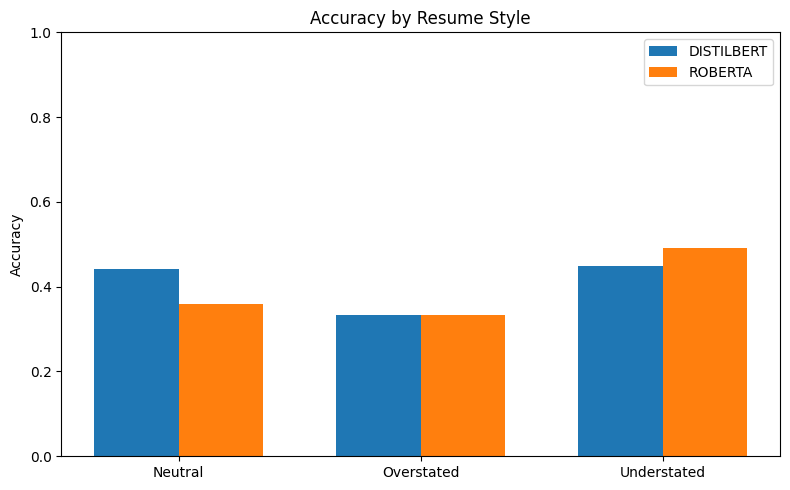

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(styles))
width = 0.35
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    accs = [model_df[model_df['style'] == s]['correct'].mean() for s in styles]
    ax.bar(x + i*width, accs, width, label=model_name.upper())
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Resume Style')
ax.set_xticks(x + width/2)
ax.set_xticklabels(['Neutral', 'Overstated', 'Understated'])
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Metric 2: Inconsistency Rate

In [4]:
print("INCONSISTENCY RATE")
print("=" * 50)
inconsistency_rates = {}
for model_name in model_names:
    model_df = results_df[results_df['model'] == model_name]
    inconsistent = sum(1 for idx in df.index if len(model_df[model_df['idx'] == idx]['prediction'].unique()) > 1)
    rate = inconsistent / len(df) * 100
    inconsistency_rates[model_name] = rate
    print(f"{model_name.upper()}: {inconsistent}/{len(df)} ({rate:.1f}%)")

INCONSISTENCY RATE
DISTILBERT: 49/120 (40.8%)
ROBERTA: 112/120 (93.3%)


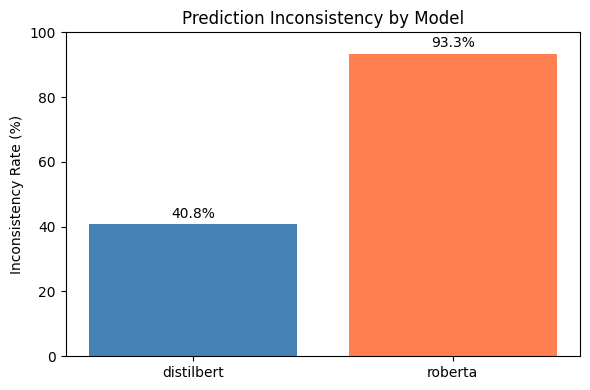

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(model_names, [inconsistency_rates[m] for m in model_names], color=['steelblue', 'coral'])
ax.set_ylabel('Inconsistency Rate (%)')
ax.set_title('Prediction Inconsistency by Model')
ax.set_ylim(0, 100)
for i, m in enumerate(model_names):
    ax.text(i, inconsistency_rates[m] + 2, f'{inconsistency_rates[m]:.1f}%', ha='center')
plt.tight_layout()
plt.show()

---
## Metric 3: Rank Difference

In [6]:
print("RANK DIFFERENCE BY STYLE")
print("=" * 50)
for model_name in model_names:
    print(f"\n{model_name.upper()}")
    model_df = results_df[results_df['model'] == model_name]
    for style in styles:
        diff = model_df[model_df['style'] == style]['rank_diff'].mean()
        print(f"  {style:<15}: {diff:+.3f}")

RANK DIFFERENCE BY STYLE

DISTILBERT
  neutral        : +0.583
  overstated     : +0.917
  understated    : +0.550

ROBERTA
  neutral        : +0.733
  overstated     : +0.925
  understated    : -0.433


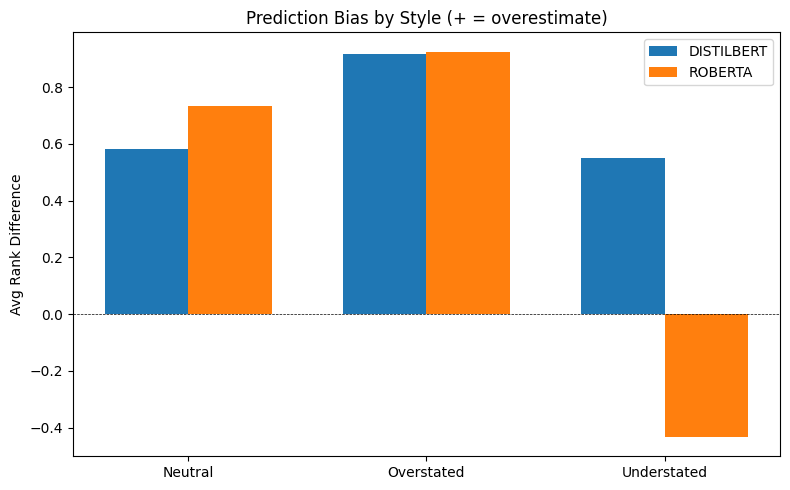

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(styles))
width = 0.35
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    diffs = [model_df[model_df['style'] == s]['rank_diff'].mean() for s in styles]
    ax.bar(x + i*width, diffs, width, label=model_name.upper())
ax.set_ylabel('Avg Rank Difference')
ax.set_title('Prediction Bias by Style (+ = overestimate)')
ax.set_xticks(x + width/2)
ax.set_xticklabels(['Neutral', 'Overstated', 'Understated'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()